In [1]:
import numpy as np
import math
from numpy import exp
import random
import matplotlib.pyplot as plt

# Hiperparametreler

In [17]:
drone_count  = 4     # drone sayısı
population   = 250   # popülasyon sayısı
path_len     = 80    # Toplam yol uzunluğu
start_x    = 6       # Başlangıç x değeri
start_y    = 2       # Başlangıç y değeri
mu_p         = 0.01  # Mutasyon ihtimali
generation   = 200   # Jenerasyon sayısı

angle_weight      = 2   # Loss hesaplamalırında angle değerinin katsayısı
distance_weight   = 3   # Loss hesaplamalırında distance değerinin katsayısı
unscanned_weight  = 12  # Loss hesaplamalırında unscanned_area değerinin katsayısı

In [3]:
# Global liste değişkenleri
lossgraphval = []
areagraphval = []
distgraphval = []

dist = []
area = []

In [4]:
# Boş bir board oluşturma
def create_board(size):
    return np.zeros((size,size), dtype=int)

In [5]:
# Verilen sayılar ile gideceğimiz yollar belirleniyor. Saat gibi düşünecek olursak 1 -> 12'ye denk geliyor ve saat yönünde 45 derece açı ile değişiyor.
directions = {1:0, 2:45, 3:90, 4: 135, 5:180, 6:225, 7:270, 8:315}

#Eğer açılar arasındaki fark 180 dereceden büyük ise, o açıyı 360'dan çıkararak asıl değerini bulabiliriz.
def aci_hesaplama(dir1, dir2):
    if abs(dir1 - dir2) > 180:
        return 360 - abs(dir1 - dir2)
    else:
        return abs(dir1 - dir2)

In [6]:
def path_olusturma(population, path_len):
    # Dronenun ilk başta kullanması için bir yol hesaplıyoruz
    return np.random.randint(1,9,size=(population, path_len))

In [7]:
def yer_degis(x, y, direction):
    # Dronenun yönüne göre bir sonraki adımındaki konumunu hesaplıyoruz
    if direction == 1:
        return x-1, y
    if direction == 2:
        return x-1, y+1
    if direction == 3:
        return x, y+1
    if direction == 4:
        return x+1, y+1
    if direction == 5:
        return x+1, y
    if direction == 6:
        return x+1, y-1
    if direction == 7:
        return x, y-1
    if direction == 8:
        return x-1, y-1

In [8]:
def yol_hesaplama(board, path, start_x, start_y):
    # Bu fonksiyonda droneların gittiği yolu board adlı matriste işaretliyoruz 
    scanned_area = 1
    angle_sum = 0
    dist_from_initial = 0  
    # Yukarıdaki değişkenlerde taranmış alanları, kaç derece döndüğünü, ve droneların
    # son noktadaki halinin başlangıç noktasına uzaklığını tutuyoruz.
    drone_moves = len(path) // drone_count
    # drone_moves değişkeninde bir dronenun kaç adım hareket edeceğini tutuyoruz
    for z in range(drone_count):
        # Drone sayısına göre for döngüsünü çalıştırıyoruz
        did_start = 0
        # Dronenun ilk hareketini kontrol etmek için did_start değişkenini tutuyoruz
        x, y = start_x, start_y
        # x ve y değişkenlerine ilk olarak başlangıç noktasını atıyoruz bu değişkenler
        # sonrasında dronenun konumunu tutacak
        board[x,y] = 1
        # İlk noktayı otomatik olarak gezilmiş yapıyoruz
        arr = path[z*drone_moves:(z+1)*drone_moves]
        # arr değişkeninde sıradaki dronenun path dizisinden aldığımız hareket bilgilerini tutuyoruz
        
        for step, i in enumerate(arr):    
            # step değişkeninde kaçıncı adımda olduğumuzu i değişkeninde adımın yönünü tutuyoruz
            tmp_x, tmp_y = yer_degis(x, y, i)
            # tmp değişkenlerinde dronenun bir sonraki harekette gitme ihtimalinin olduğu yerleri tutuyoruz
            if not (tmp_x < 0 or tmp_x > 8 or tmp_y < 0 or tmp_y > 8):
                # Eğer dronenun hareketi sonucunda dışarı çıkıyor mu diye kontrol ediyoruz
                # Dışarı çıkıyorsa dronenun konumunu değiştirmiyoruz
                if did_start == 0:
                    # Dronenun ilk hareketi yapılıyorsa önceki hareketine şu anki hareketini atıyorum 
                    old_i = i
                    did_start = 1
                # Dronenun konumunu değiştiriyoruz
                x = tmp_x
                y = tmp_y
                
                # Eğer alan daha önce gezilmemişse taranmış alan sayısını arttırıyorum
                if board[x,y] == 0:
                    scanned_area += 1
                # Eğer drone sayısı
                if drone_count == 1:
                    board[x,y] = step+2
                else:
                    board[x,y] = z+1
                # Dronenun adımda döndüğü açıyı önceki adımını kullanarak hesaplıyoruz 
                angle_sum += aci_hesaplama(directions[old_i], directions[i])
                # Yeni önceki adımı atıyorum
                old_i = i   
        # Dronenun ilk konumuna göre olan uzaklığını hesaplıyorum
        dist_from_initial += math.sqrt((start_x - x)**2 + (start_y - y)**2) 
    # Gerekli değerleri returnluyorum
    return angle_sum, dist_from_initial/drone_count, 81-scanned_area,board  # board eklendi

In [9]:
def compute_losses_of_drone_paths(drone_paths,gen):
    
    global losses  # Loss değerlerimizi tuttuğumuz global değişkenimiz
    losses = np.zeros((drone_paths.shape[0],1))
    min_loss = 100 # Her generation için en düşük loss değerli board'u ve değerleri saklayabilmek için bir min_loss değeri tanımlıyoruz.
    min_unscaned_area = 100 # Her generation için en düşük loss değerli indexin, min_unscaned_area tutmak için
    best_board = [] # Her generation için en düşük loss değerli indexin, board'u tutmak için tanımlıyoruz.
    
    for i,ind in enumerate(drone_paths): #  O generation icin en iyi loss degerlerinin ve en iyi loss degerli pathin degerlerinin saklandıgı dongu.
        board = create_board(9) 
        
        angle_sum, dist_from_initial, unscanned_area, board = yol_hesaplama(board, ind, start_x, start_y) 
        
        norm_angle_sum = angle_sum/(14400-(drone_count*180)) # Toplam açıların loss hesaplamaları için normalize edilmiş hali
        norm_dist_from_initial = dist_from_initial/12.72792206135786 # Toplam distanceların loss hesaplamaları için normalize edilmiş hali
        norm_unscanned_area = unscanned_area/80 # Toplam unscanned areaların loss hesaplamaları için normalize edilmiş hali
        area.append(unscanned_area) # generation icindeki tüm pathlerin unscaned area degerleri listede tutuluyor.
        dist.append(dist_from_initial) # generation icindeki tüm pathlerin disrance degerleri listede tutuluyor.
        loss = angle_weight*norm_angle_sum + distance_weight*norm_dist_from_initial + unscanned_weight*norm_unscanned_area #loss hesabı
        
        if loss < min_loss: # eger loss bu generation'ın en düşük loss değeri ise değerlerimizi saklıyoruz
            min_loss = loss
            best_board = board
            min_unscaned_area = unscanned_area
        
        losses[i] = loss        
        text = f"{min_loss:.5f}" # nin_loss'u yazdırmak için gerekli dönüşüm
        
    if gen % 10 == 0 or gen == 1: # Her 10 generationda bir best_board'u yazdırıyoruz.
        fig, ax = plt.subplots()
        im = ax.imshow(best_board)
        ax.set_title("Generation "+ str(gen) + "  Loss: "+ text + "  Unscanned Area: " + str(min_unscaned_area))
        for i in range(0,9):
            for j in range(0,9):
                text = ax.text(j, i, best_board[i, j],
                               ha="center", va="center", color="w") 

In [10]:
def softmax(vector): # Softmax fonksiyonu ile loss değerlerimizden ihtimal hesaplamaya geçiş yapıyoruz.
    e = exp(vector)
    return e / e.sum()

def crossover(): 
    losses1 = softmax((losses*(-1)).tolist()) # İhtimalleri losses1 listesine yerleştirdik
    drone_paths1 = random.choices(drone_paths, weights = losses1, k = population) # İhtimallere bakarak seçim yapıyoruz.
    dronenum = path_len//drone_count # Bir drone'un gideceği mesafe
    

    for i in range(0,len(drone_paths),2): # crossover işlemi her sıralı 2'li için yapılacak.
         for k in range(drone_count): # Pathimiz drone count kadar parçaya bölünüyor, daha sonra o parçalar kendi içinde crossover yapacak.
            slice_point = random.randint((k*dronenum), (k+1)*dronenum-1) # Crossover'ın nereden yapılacağı random belirleniyor.           
            temp = drone_paths1[i][k*dronenum:slice_point] # Parçalar ayrılıp crossover yapılıyor.
            drone_paths1[i][k*dronenum:slice_point]= drone_paths1[i+1][k*dronenum:slice_point] 
            drone_paths1[i+1][k*dronenum:slice_point] = temp
  
            
    for i,k in enumerate(drone_paths1):
        drone_paths[i] = k
    return drone_paths

In [11]:
def mutation(drone_paths, mu_p):
    # Mutasyon için mutasyonların ihtimalinin olduğu bir dizi tutuyoruz
    mut_prob = [mu_p, 1-mu_p]
    # Bunun yanında seçim yapılması için ihtimallerler aynı sırada bir True False dizisi tutuyoruz
    mut = [True, False]
    for i in range(drone_paths.shape[0]):
        for j in range(drone_paths.shape[1]):
            # Crossover sonucunda oluşan bütün yollardaki elemanları dolaşıyoruz
            # mutasyon ihtimalini kullanarak choice adlı değeri elde ediyoruz
            choice = random.choices(mut, mut_prob)
            # Eğer choice değeri True gelirse o anki elemanı 1 ve 8 arasındaki rastgele bir sayı ile değiştiriyoruz
            if choice[0]:
                tmp = np.random.randint(1,9,size=1)
                drone_paths[i][j] = tmp
    # Yeni drone yollarını returnluyoruz
    return drone_paths

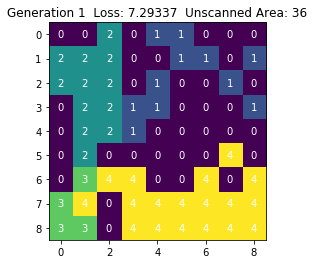

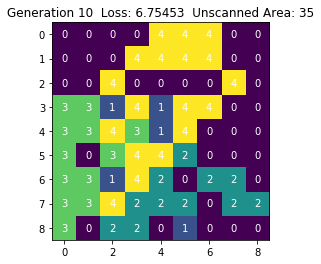

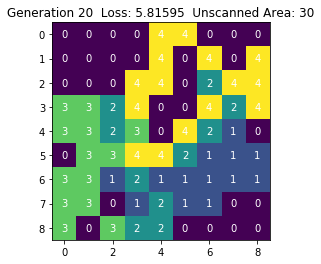

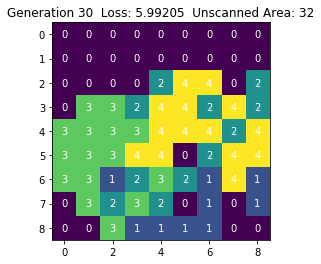

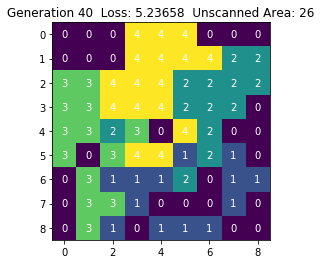

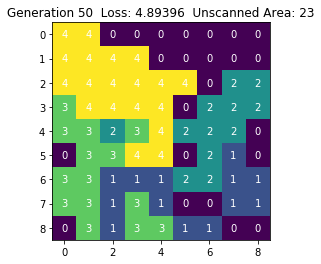

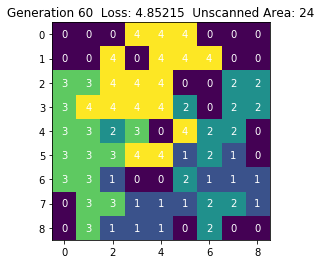

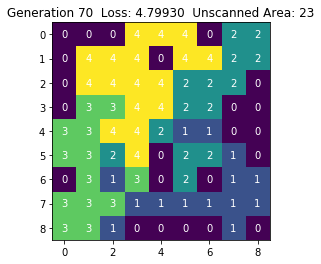

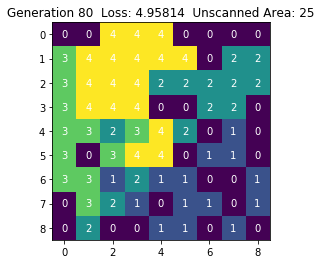

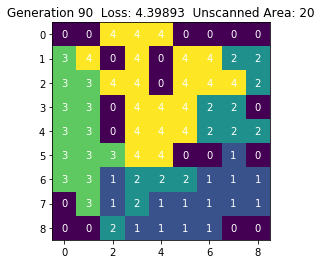

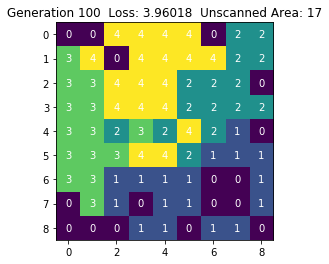

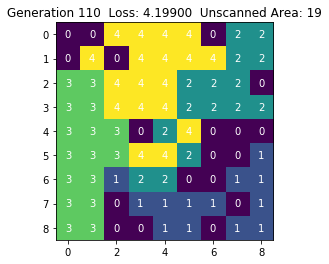

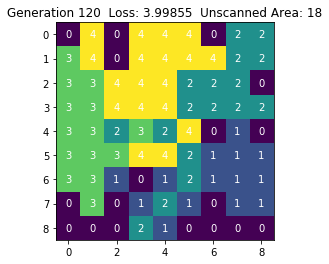

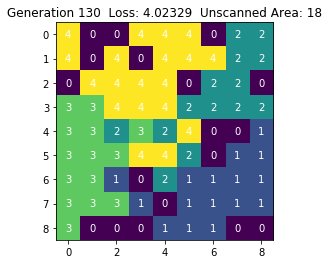

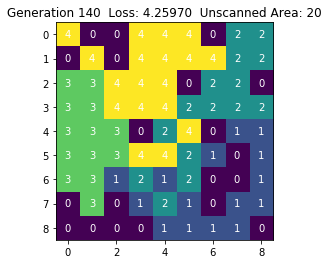

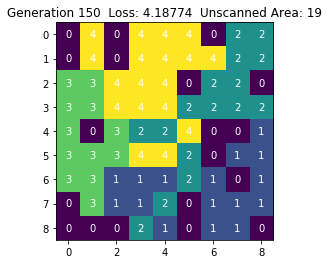

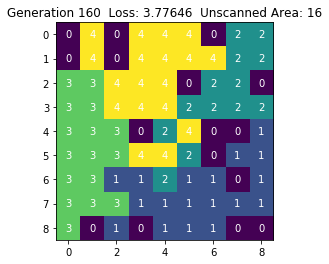

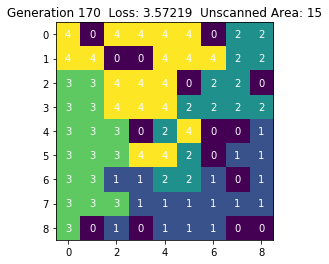

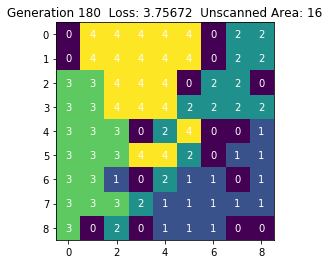

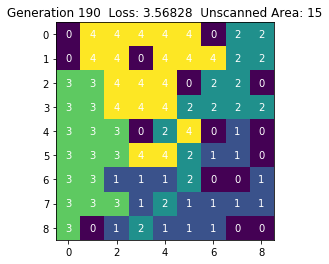

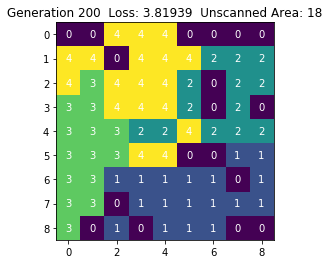

In [18]:
drone_paths = path_olusturma(population, path_len) # drone_paths listesine popülasyon sayısı kadar rastgele yol oluşturuluyor.

for i in range(generation):   # Her generation için işlemler bu döngü içinde yapılıyor.
    
    compute_losses_of_drone_paths(drone_paths,i+1) # Generation içindeki losslar hesaplanıyor
    index = np.argmin(losses) # En düşük loss değerinin indexi kaydediliyor.
    lossgraphval.append(losses[index]) # lossgraphval listesinin sonuna her generation'ın en düşük loss değeri ekleniyor. 
    distgraphval.append(dist[index]) # distgraphval listesinin sonuna her generation'ın en düşük distance değeri ekleniyor.
    areagraphval.append(area[index]) # areagraphval listesinin sonuna her generation'ın en düşük unscanned area değeri ekleniyor.
    area = []
    dist = []
    
    # Crossover ve Mutation yapılıp yeni generation oluşturuluyor.
    drone_paths = crossover() 
    drone_paths = mutation(drone_paths, mu_p)        

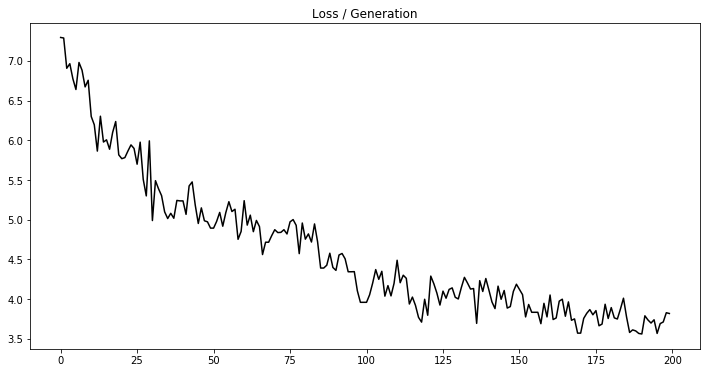

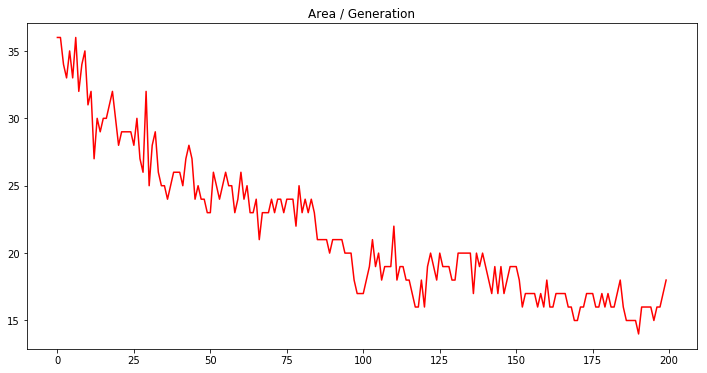

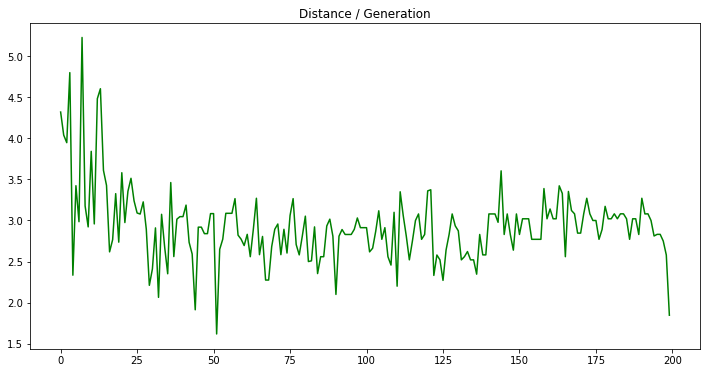

In [19]:
# Loss,Unscanned area ve Distance değerlerinin generation ile olan ilişkilerinin grafiğie aktarılması.
fig, lossx = plt.subplots(figsize=(12, 6))

lossx.set_title("Loss / Generation")
lossx.plot(lossgraphval, color='black')

fig, arx = plt.subplots(figsize=(12, 6))

arx.set_title("Area / Generation")
arx.plot(areagraphval, color='red')

fig, distx = plt.subplots(figsize=(12, 6))

distx.set_title("Distance / Generation")
distx.plot(distgraphval, color='green')

lossgraphval = []
areagraphval = []
distgraphval = []